In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# import necessary packages

import os
import numpy as np
import pandas as pd

import ast

import seaborn as sns
from matplotlib import pyplot as plt

from collections import defaultdict

from sklearn.feature_selection import f_classif
from stat_utils import *

In [2]:
DIR_WSI = "/Users/jinzhou/Desktop/USCAP/data/wsi"
DIR_ANN = "/Users/jinzhou/Desktop/USCAP/data/ann_geojsons"
DIR_SAVE_RESULTS = "/Users/jinzhou/Desktop/USCAP/results"
DIR_SAVE_FIGURE = "/Users/jinzhou/Desktop/USCAP/results/figures"

## Process thickness.csv

In [3]:
PATH_STAT_MANUAL = os.path.join(DIR_SAVE_RESULTS, "thickness.csv")
PATH_STAT_DL = os.path.join(DIR_SAVE_RESULTS, "thickness_dl.csv")

In [4]:
# read thickness analysis
def read_df_from_csv(path_csv):
    df = pd.read_csv(path_csv)
    # original list in path_csv is read as string, for example "[0.2, 0.1, ...]"
    # ast.literal_eval converts string to python literal structures
    df['Thickness_Media_Abs'] = df['Thickness_Media_Abs'].apply(lambda x: ast.literal_eval(x))
    df['Thickness_Intima_Abs'] = df['Thickness_Intima_Abs'].apply(lambda x: ast.literal_eval(x))
    df['Thickness_Wall_Abs'] = df['Thickness_Wall_Abs'].apply(lambda x: ast.literal_eval(x))

    return df

def clean(df_thick):
    # A few adjustment to match qupath annotations to labels assignment
    # 1. In "11_26609_023_512 L4 TRI", A8 -> A08
    # 2. In "11_26609_009_008 L10 TRI", there are two A26, where the second one should be A27
    # 3. discard "12_26609_021_507 L03 TRI" from analysis

    df_thick.loc[:, 'Artery_ID'] = df_thick.loc[:, 'Artery_ID'].str.split('_').str[0]

    if '11_26609_009_008 L10 TRI' in df_thick.loc[:, 'WSI_ID'].values:
        df_thick.loc[(df_thick.loc[:, 'WSI_ID'] == '11_26609_009_008 L10 TRI') & 
               (df_thick.loc[:, 'Artery_ID'] == 'A26'), 'Artery_ID'] = ['A26', 'A27']

    if '11_26609_023_512 L4 TRI' in df_thick.loc[:, 'WSI_ID'].values:
        df_thick.loc[(df_thick.loc[:, 'WSI_ID'] == '11_26609_023_512 L4 TRI') & 
               (df_thick.loc[:, 'Artery_ID'] == 'A8'), 'Artery_ID'] = 'A08'

    if "12_26609_021_507 L03 TRI" in df_thick.loc[:, 'WSI_ID'].values:
        df_thick = df_thick[df_thick.loc[:, "WSI_ID"]!="12_26609_021_507 L03 TRI"]

    # Set and WSI_Artery_ID, ignoring media and intima index
    df_thick.loc[:, 'WSI_Artery_ID'] = df_thick.loc[:, 'WSI_ID'] + '_' \
        + df_thick.loc[:, 'Artery_ID']
    # For arteries with multiple lumen/intima areas, we pick the one with maxium lumen area
    df_thick = df_thick.sort_values('Area', ascending=False).drop_duplicates(['WSI_Artery_ID'])
    return df_thick

In [5]:
df_thick_manual = read_df_from_csv(PATH_STAT_MANUAL)
df_thick_manual = clean(df_thick_manual)

df_thick_dl = read_df_from_csv(PATH_STAT_DL)
df_thick_dl = clean(df_thick_dl)

/Users/jinzhou/anaconda3/envs/cv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [6]:
df_thick_manual = df_thick_manual.loc[df_thick_manual.loc[:, "WSI_Artery_ID"].isin(df_thick_dl.loc[:, "WSI_Artery_ID"].values), :]

# Decid Which to Analyze

In [7]:
df_thick = df_thick_manual

## Process "Labels.xlsx"

In [8]:
PATH_LABEL = "/Users/jinzhou/Desktop/USCAP/data/labels_updated.xlsx"

In [9]:
df_label = pd.ExcelFile(PATH_LABEL)

# Only read the first sheet of the excel file
sheet_name = df_label.sheet_names[0]
df_label = df_label.parse(sheet_name, skiprows=1) # skip the first row
# Use Artery_ID as row index and WSI_ID as column name
df_label = df_label.rename(columns = {'Unnamed: 0':'Artery_ID'}).set_index("Artery_ID")

In [10]:
# replace labels of strings to integers.
df_label = df_label.replace({"without arteriosclerosis": 0, 
                             "mild arteriosclerosis": 1, 
                             "mild hyalinosis": 1, 
                             "moderate arteriosclerosis": 2,
                             "severe arteriosclerosis": 3, 
                             "-": np.nan, " - ": np.nan})


## Clip and Normalize Thickness

In [11]:
df_features_label = pd.DataFrame(columns = ["WSI_Artery_ID", "Media Average", "Media Skewness", "Media Power", 
                                             "Intima Average", "Intima Skewness", "Intima Power",
                                             "Label"])

for index, row in df_thick.iterrows():
    thick_media = row["Thickness_Media_Abs"]
    thick_intima = row["Thickness_Intima_Abs"]
    thick_wall = row["Thickness_Wall_Abs"]
#     if not (row["WSI_ID"] == "11_26609_000_011_L02_TRI" and row["Artery_ID"] == "A08"): 
#         continue
    path_save_hist = os.path.join(DIR_SAVE_FIGURE, row["WSI_ID"], row["Artery_ID"]+"_hist.png")
    
    # clip and normalize
    thick_media, thick_intima = clip_normalize(thick_media = row["Thickness_Media_Abs"], 
                                               thick_intima = row["Thickness_Intima_Abs"], 
                                               thick_wall = row["Thickness_Wall_Abs"], plot_hist=False)
    # feature extraction
    row_features_label = {}
    features_media = get_features(row_features_label, thick_media, "Media")
    features_intima = get_features(row_features_label, thick_intima, "Intima")
    row_features_label["WSI_Artery_ID"] = row["WSI_Artery_ID"]
    row_features_label["Label"] = df_label.loc[row["Artery_ID"], row["WSI_ID"]]
    df_features_label = df_features_label.append(row_features_label, ignore_index=True)

In [12]:
df_features_label.head()

,WSI_Artery_ID,Media Average,Media Skewness,Media Power,Intima Average,Intima Skewness,Intima Power,Label
0,11_26609_000_013_L02 TRI_A06,0.325099,0.617807,0.116973,0.674901,-0.617807,0.466776,3.0
1,11_26609_027_005 L03 TRI_A08,0.685241,-1.066079,0.486147,0.314759,1.066079,0.115666,2.0
2,11_26609_000_011_L02_TRI_A17,0.733365,-0.238811,0.551692,0.266635,0.238811,0.084963,1.0
3,11_26609_020_006 A15 TRI_A25,0.322593,-0.309259,0.123101,0.677407,0.309259,0.477914,2.0
4,11_26609_020_006 A15 TRI_A05,0.497028,-0.057800,0.290337,0.502972,0.057800,0.296280,2.0


## HeatMap, Boxtplot and Kendall Tau Analysis

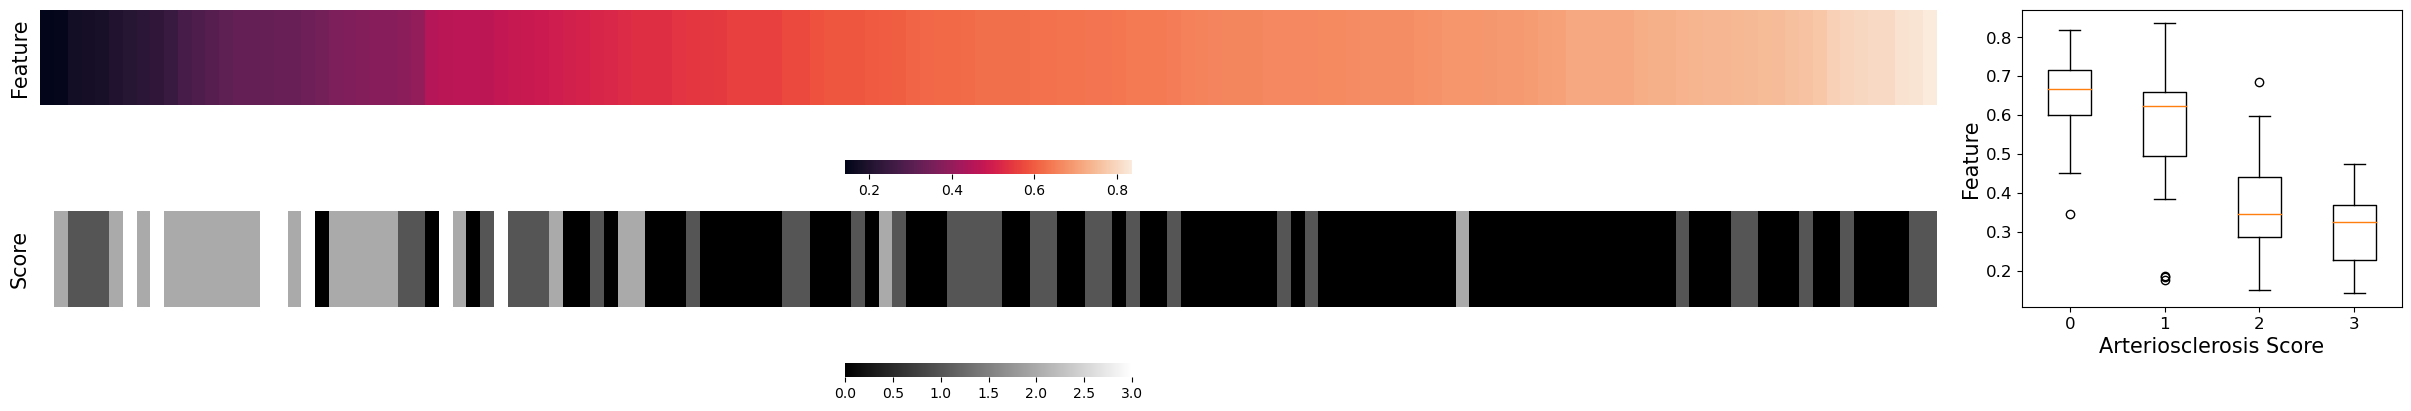

Feature: Media Average; kendalltau: rho = -0.47, p = 0.000000


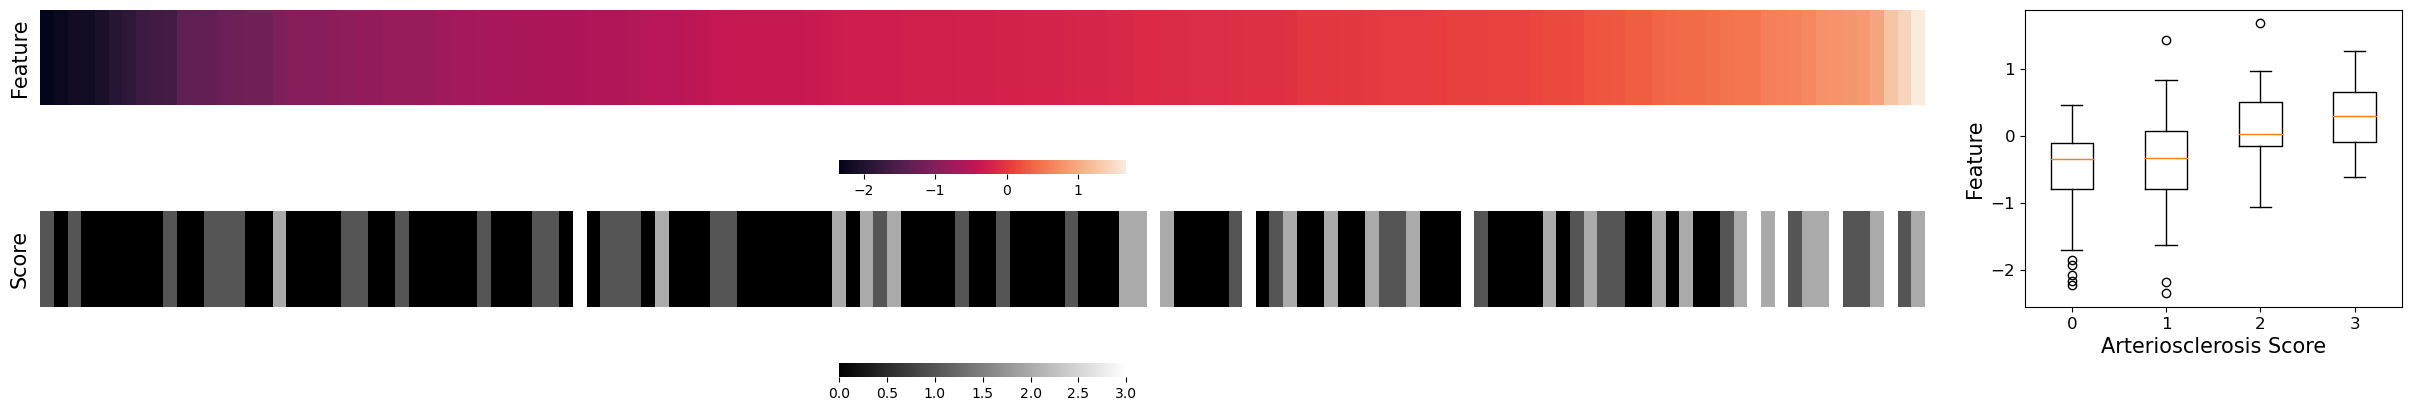

Feature: Media Skewness; kendalltau: rho = 0.26, p = 0.000062


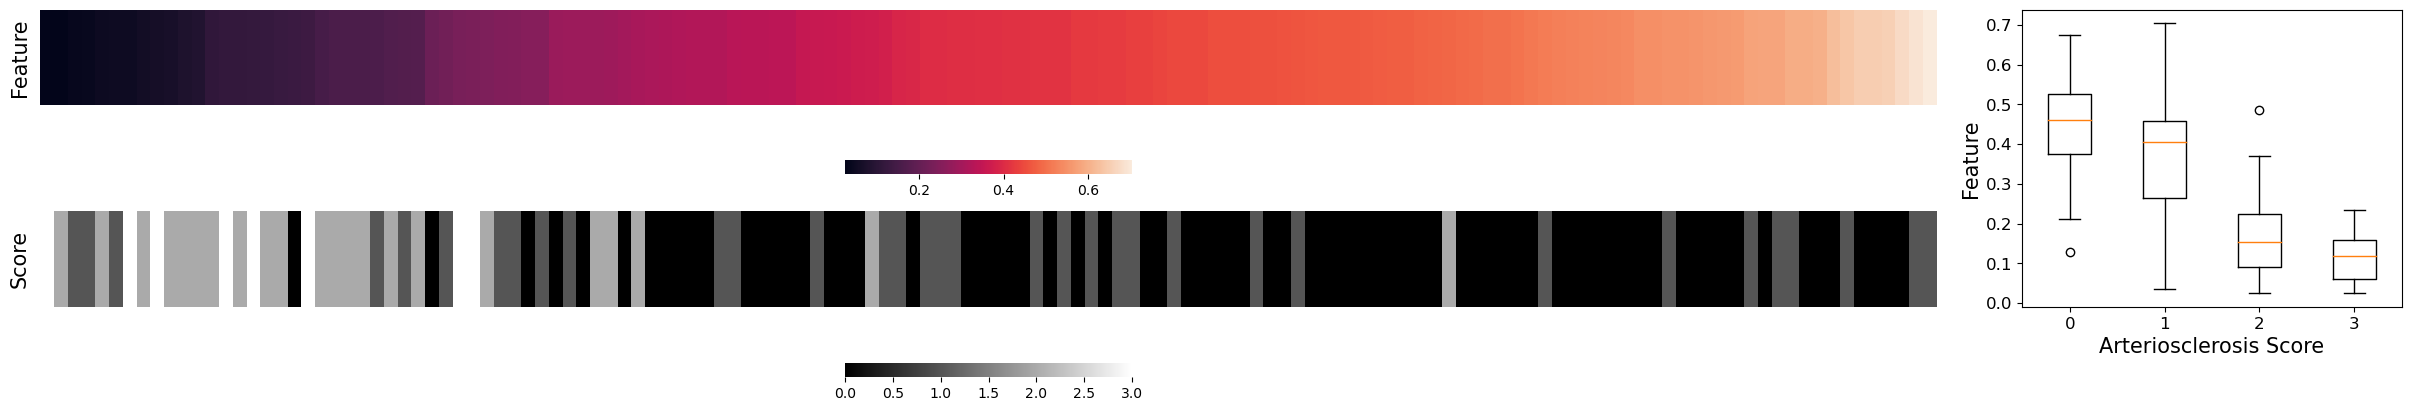

Feature: Media Power; kendalltau: rho = -0.46, p = 0.000000


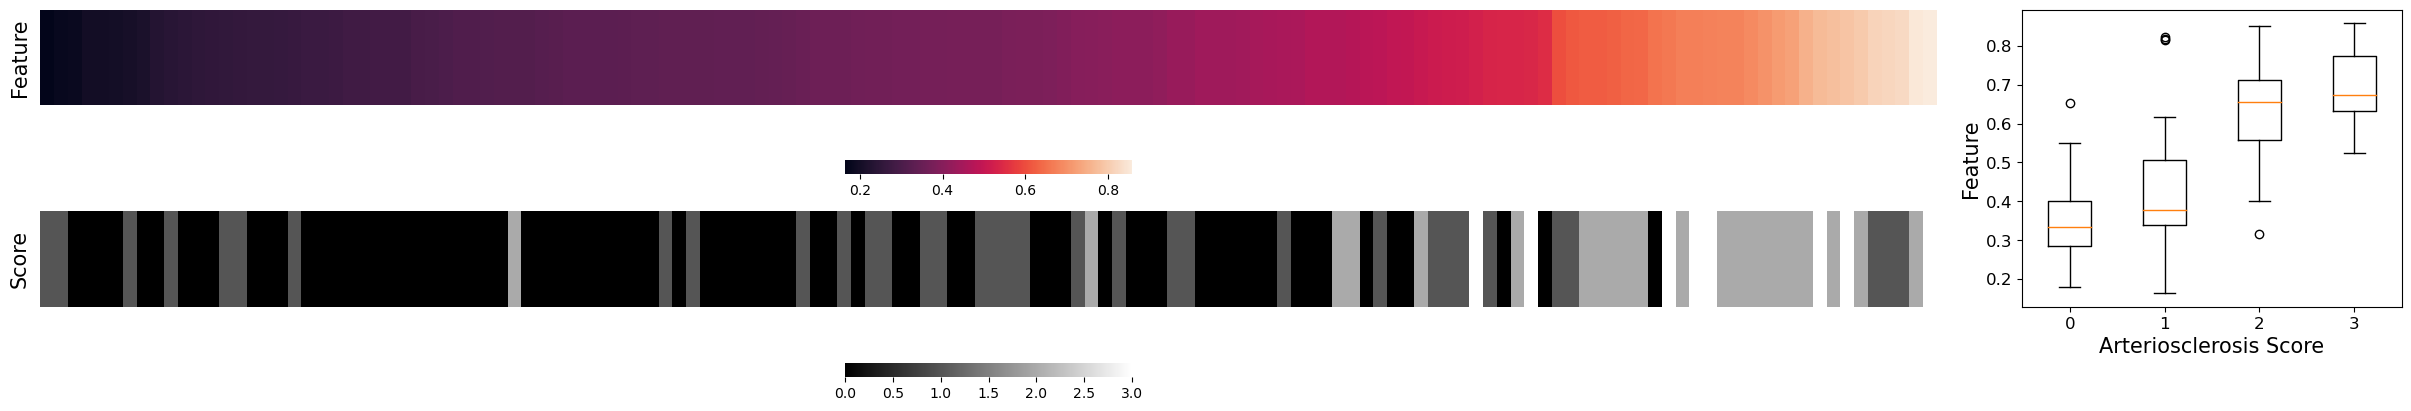

Feature: Intima Average; kendalltau: rho = 0.47, p = 0.000000


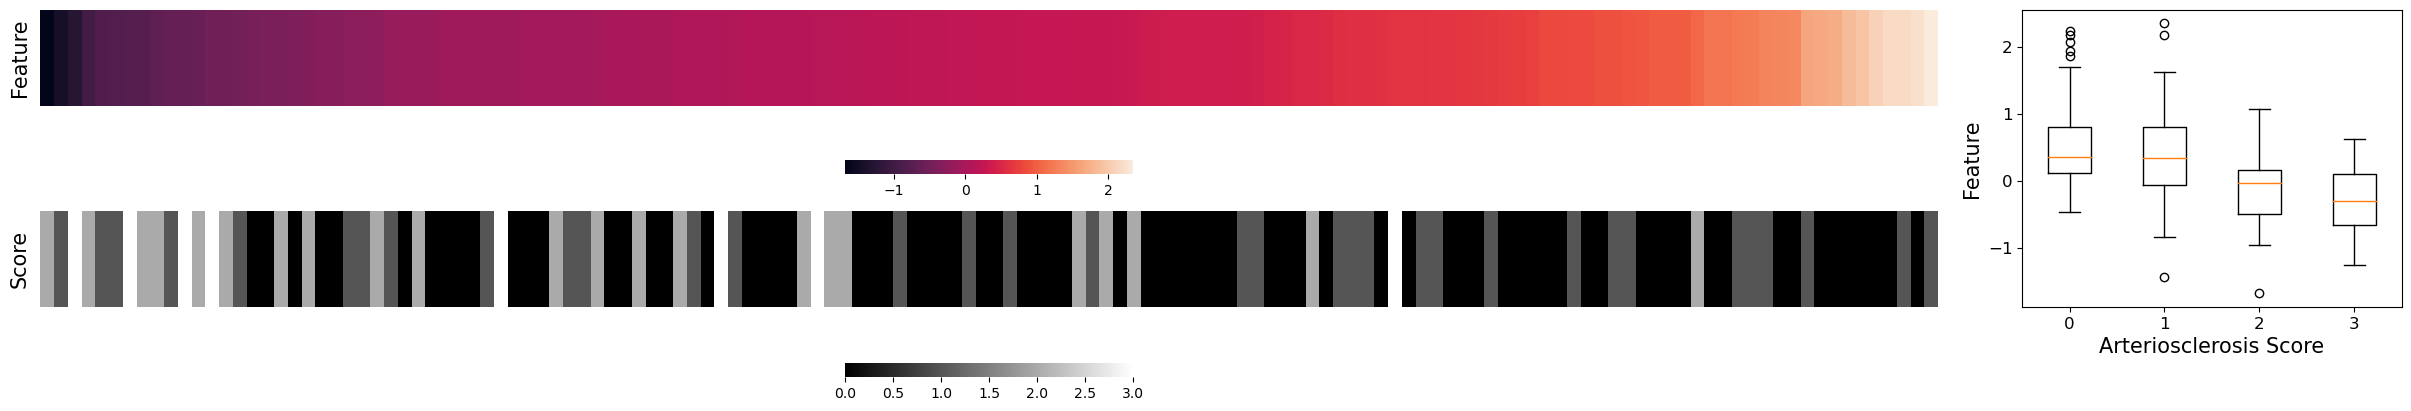

Feature: Intima Skewness; kendalltau: rho = -0.26, p = 0.000062


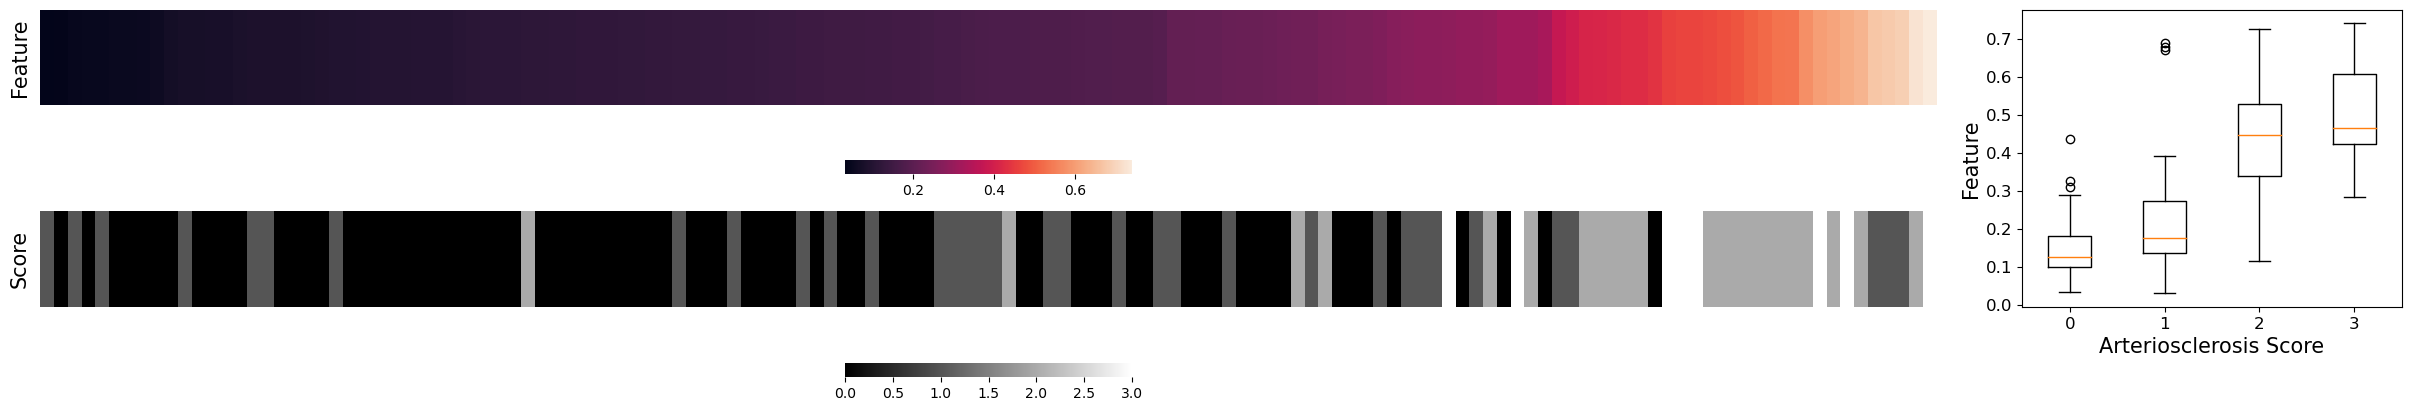

Feature: Intima Power; kendalltau: rho = 0.48, p = 0.000000


In [13]:
def heatmap_features(df_features_label, feature_name):
    xticklabels = df_features_label.loc[:, "WSI_Artery_ID"].values
    features = df_features_label.loc[:, feature_name].values
    labels = df_features_label.loc[:, "Label"].values

    fig = plt.figure(constrained_layout=True, figsize=(24, 4))
    axs = fig.subplot_mosaic([['TopLeft', 'Right'],['BottomLeft', 'Right']],
                              gridspec_kw={'width_ratios':[5, 1]})
    
    # heatmap
    idx_sort = features.argsort()
    sns.heatmap(features[idx_sort].reshape(1, -1), cbar=True, 
                cbar_kws = dict(use_gridspec=False,location="bottom"), 
                ax=axs['TopLeft'])
    axs['TopLeft'].set_xticks([])
    axs['TopLeft'].set_yticks([])
    axs['TopLeft'].set_ylabel("Feature", fontsize=15)
    sns.heatmap(labels[idx_sort].reshape(1, -1), cmap='gray', cbar=True, 
                cbar_kws = dict(use_gridspec=False,location="bottom"), 
#                 xticklabels =xticklabels[idx_sort] ,
                ax=axs['BottomLeft'])
    axs['BottomLeft'].set_xticks([])
    axs['BottomLeft'].set_yticks([])
    axs['BottomLeft'].set_ylabel("Score", fontsize=15)
    
    # box plot
    features_label_0 = features[labels==0]
    features_label_1 = features[labels==1]
    features_label_2 = features[labels==2]
    features_label_3 = features[labels==3]
    axs['Right'].boxplot([features_label_0, features_label_1, features_label_2, features_label_3])
    axs['Right'].set_xticklabels([0,1,2,3], fontsize=12)  
    axs['Right'].tick_params(axis="y", labelsize=12)
    axs['Right'].set_xlabel("Arteriosclerosis Score", fontsize=15)
    axs['Right'].set_ylabel("Feature", fontsize=15)
    
    # Kendall Tau
    rho, p_val = scipy.stats.kendalltau(features, labels)
    plt.show()
    print('Feature: {}; kendalltau: rho = {:.2f}, p = {:.6f}'.format(feature_name, rho, p_val))
    
for col in ["Media Average", "Media Skewness", "Media Power", 
            "Intima Average", "Intima Skewness", "Intima Power"]:
    heatmap_features(df_features_label, col)

-0.4722009497116256 7.614157960932867e-13
-0.4649897361130883 1.6835481040105238e-12
0.4722009497116256 7.614157960932867e-13
0.4767413434588528 4.592258175288309e-13


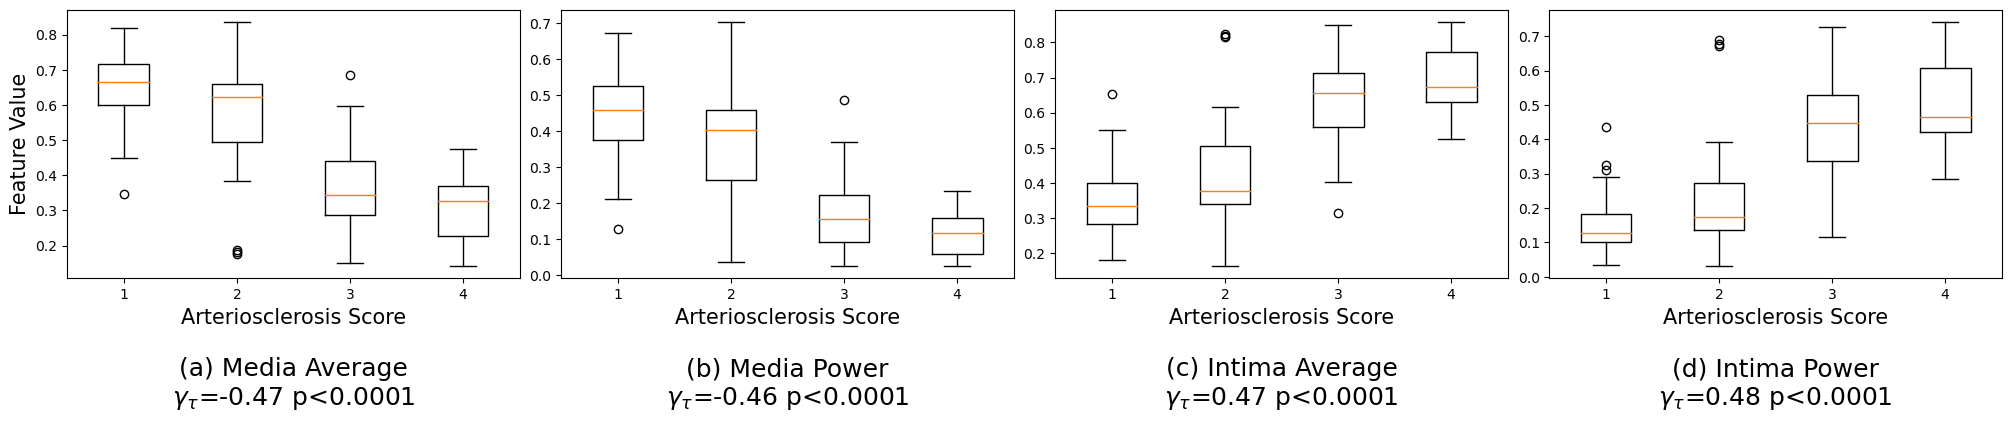

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(20, 4))
axs = fig.subplots(1, 4)

for i, feature_name in enumerate(["Media Average", "Media Power", "Intima Average", "Intima Power"]):
    features = df_features_label.loc[:, feature_name].values
    labels = df_features_label.loc[:, "Label"].values
    
    features_label_0 = features[labels==0]
    features_label_1 = features[labels==1]
    features_label_2 = features[labels==2]
    features_label_3 = features[labels==3]
    rho, p_val = scipy.stats.kendalltau(features, labels)
    print(rho, p_val)
    axs[i].boxplot([features_label_0, features_label_1, features_label_2, features_label_3])    
    axs[i].set_xlabel("Arteriosclerosis Score", fontsize=15)
    if i == 0:
        axs[i].set_ylabel("Feature Value", fontsize=15)
    axs[i].set_xlabel("Arteriosclerosis Score", fontsize=15)
    axs[i].set_title( "("+"abcde"[i]+") " + feature_name + "\n" + r"$\gamma_{\tau}$" + "={:.2f}".format(rho) + " p<0.0001",
                     y=-0.4,pad=-14, fontsize=18)
